In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pathlib
import pickle
from pathlib import Path



import jax.numpy as jnp
from jax import hessian, jacfwd, jacrev, jit
from scipy.linalg import eig

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets.widgets import HBox, VBox, Label

sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from local_utils import *

In [2]:
def loss_u(pattern, D_u, rho_u, sigma_u, mu_u, kappa_u, 
          u, u_xx, u_yy, u_t, v):
        
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
    return np.sum(f_u**2)

def loss_v(pattern, D_v, rho_v, sigma_v, kappa_u,
           v, v_xx, v_yy, v_t, u):    
        
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
    
    return np.sum(f_v**2)

def loss(pattern, D_u, D_v, rho_u, sigma_u, mu_u, kappa_u, rho_v, sigma_v,
         u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t ):
    return (loss_u(pattern, D_u, rho_u, sigma_u, mu_u, kappa_u,
                   u, u_xx, u_yy, u_t, v) +
            loss_v(pattern, D_v, rho_v, sigma_v, kappa_u, v,
                    v_xx, v_yy, v_t, u))



In [3]:
pattern = None
x_slice = None
y_slice = None
def load_domain(simulation_name, x_range=(30, 65), y_range=(50, 85), steps=10, title_1="u", title_2="v"):
    disable_all_ranges(True)
    def plot_d(d, title_1="u", title_2="v"):
        x = np.arange(0, d[0,:,:, -1].T.shape[0])[x_slice]
        y = np.arange(0, d[0,:,:, -1].T.shape[1])[y_slice]
        X, Y = np.meshgrid(x, y, indexing='ij')
        _ = plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.title(f"{title_1}")
        plt.imshow(d[0,:,:, -1].T, origin='lower')
        plt.colorbar(shrink=.75)
        plt.scatter(X, Y, alpha=.5)
        plt.subplot(122)
        plt.title(f"{title_2}")
        plt.imshow(d[1,:,:, -1].T, origin='lower')
        plt.colorbar(shrink=.75)
        plt.scatter(X, Y, alpha=.5)    
        plt.show()
        
    
    x_slice=slice(x_range[0],x_range[1],steps)
    y_slice=slice(y_range[0],y_range[1],steps)    
    pattern = load(simulation_name, 
                   x_slice,
                   y_slice,
                   data_time_start=-3, 
                   data_time_len=2,
                   data_time_step=1,
                   verbose=False)
    globals()["y_slice"] = y_slice
    globals()["x_slice"] = x_slice
    globals()["pattern"] = pattern
    plot_d(pattern.c_domain, title_1="u", title_2="v")
    plot_d(pattern.c_xx_domain, title_1="u_xx", title_2="v_xx")
    plot_d(pattern.c_yy_domain, title_1="u_yy", title_2="v_yy")
    plot_d(pattern.c_t_domain, title_1="u_t", title_2="v_t")
    disable_all_ranges(False)
    return pattern


folders = !ls ~/test/outputs_Koch_Meinhardt_100_by_100

w_simulations = widgets.Dropdown(
    options=folders,
    value="Koch_Meinhardt_1",
    description='Simulation:',
)

w_x_range = widgets.IntRangeSlider(
    value=[30, 65],
    min=0,
    max=99,
    step=1,
    description='X range:',
    continuous_update=False,
)

w_y_range = widgets.IntRangeSlider(
    value=[50, 85],
    min=0,
    max=99,
    step=1,
    description='Y range:',
    continuous_update=False,
)
w_steps = widgets.IntSlider(
    value=10,
    min=1,
    max=20,
    step=1,
    description='Steps:',
    continuous_update=False,
)
def disable_all_ranges(value):
    w_x_range.disabled = value
    w_y_range.disabled = value
    w_steps.disabled = value
    w_simulations.disabled = value
    
w_domain_plot = widgets.interactive_output(load_domain, 
                                    {'simulation_name':w_simulations,
                                     'x_range': w_x_range,
                                     'y_range':w_y_range,
                                    'steps':w_steps})

h_box_range = HBox([w_steps, w_x_range, w_y_range])
hbox_load = HBox([w_simulations])
hbox_domain = HBox([w_domain_plot])
vbox_load = VBox([h_box_range, hbox_load, hbox_domain])
display(vbox_load)

In [4]:
u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["sigma_u"],
                     pattern.params["mu_u"], pattern.params["kappa_u"]])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

def create_loss_u():
    (u, u_xx, u_yy, u_t,
     v, v_xx, v_yy, v_t) = (pattern.c[0, ...].copy(),
                            pattern.c_xx[0, ...].copy(),
                            pattern.c_yy[0, ...].copy(),
                            pattern.c_t[0, ...].copy(),
                            pattern.c[1, ...].copy(),
                            pattern.c_xx[1, ...].copy(),
                            pattern.c_yy[1, ...].copy(),
                            pattern.c_t[1, ...].copy())
    def f(rho_u, sigma_u, mu_u, kappa_u):
        return loss_u(pattern, pattern.params["D_u"], 
                      rho_u, sigma_u, mu_u, kappa_u,
                      jnp.array(u), jnp.array(u_xx),
                      jnp.array(u_yy), jnp.array(u_t), jnp.array(v))
    return f

def create_loss_v():
    (u, u_xx, u_yy, u_t,
     v, v_xx, v_yy, v_t) = (pattern.c[0, ...].copy(),
                            pattern.c_xx[0, ...].copy(),
                            pattern.c_yy[0, ...].copy(),
                            pattern.c_t[0, ...].copy(),
                            pattern.c[1, ...].copy(),
                            pattern.c_xx[1, ...].copy(),
                            pattern.c_yy[1, ...].copy(),
                            pattern.c_t[1, ...].copy())
    def f(rho_v, sigma_v, kappa_u):
        return loss_v(pattern, pattern.params["D_v"], 
                      rho_v, sigma_v, kappa_u,
                      jnp.array(v), jnp.array(v_xx),
                      jnp.array(v_yy), jnp.array(v_t), jnp.array(u))
    return f

def create_loss():
    f1 = create_loss_u()
    f2 = create_loss_v()
    def f(rho_u, sigma_u, mu_u, kappa_u, rho_v, sigma_v):
        return f1(rho_u, sigma_u, mu_u, kappa_u) + f2(rho_v, sigma_v, kappa_u)
    return f

In [5]:
def find_Hessians():
    l_u = create_loss_u()
    H_u = hessian(l_u, [0, 1, 2, 3])

    u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["sigma_u"],
                         pattern.params["mu_u"], pattern.params["kappa_u"]])

    H_u_value = jnp.array(H_u(*u_vec_ac))
    u_eig_vals, u_eig_vects = eig(H_u_value)
    u_eig_vects = np.array([normalise(vec) for vec in  u_eig_vects])

    l_v = create_loss_v()
    H_v = hessian(l_v, [0, 1, 2])

    v_vec_ac = np.array([pattern.params["rho_v"], pattern.params["sigma_v"],
                         pattern.params["kappa_u"]])

    H_v_value = jnp.array(H_v(*v_vec_ac))
    v_eig_vals, v_eig_vects = eig(H_v_value)
    v_eig_vects = np.array([normalise(vec) for vec in  v_eig_vects])
    globals()["l_u"] = l_u
    globals()["u_vec_ac"] = u_vec_ac
    globals()["u_eig_vals"] = u_eig_vals
    globals()["u_eig_vects"] = u_eig_vects
    globals()["l_v"] = l_v
    globals()["v_vec_ac"] = v_vec_ac
    globals()["v_eig_vals"] = v_eig_vals
    globals()["v_eig_vects"] = v_eig_vects
    return (l_u, u_vec_ac, u_eig_vals, u_eig_vects, 
            l_v, v_vec_ac, v_eig_vals, v_eig_vects)


In [6]:
b_calculate_Hessians = widgets.Button(description="find directions")
def click_b_calculate_Hessians(change):
    b_calculate_Hessians.disabled=True
    find_Hessians()
    b_calculate_Hessians.disabled=False
    
b_calculate_Hessians.on_click(click_b_calculate_Hessians)

display(b_calculate_Hessians)

Button(description='find directions', style=ButtonStyle())

In [7]:
def calculate_2D_landscape(loss, vec_ac, eig_vect1, eig_vect2, extend_factor=1, size=30):
    s_line = creat_line(vec_ac, eig_vect1)
    alpha_end = 1*Euc_L(vec_ac)/Euc_L(eig_vect1)

    s_perp_line = creat_line(vec_ac, eig_vect2)
    perp_alpha_end = 1*Euc_L(vec_ac)/Euc_L(eig_vect2)
    
    line_alphas = np.linspace(-0*alpha_end, extend_factor*alpha_end, size)
    line_perp_alphas = np.linspace(-0*perp_alpha_end, extend_factor*perp_alpha_end, size)
    
    loss_2D = np.zeros((size, size))

    for i, alpha_perp in enumerate(line_perp_alphas):
        params_perp = s_perp_line(alpha_perp)
        param_shifted = vec_ac + params_perp    
        s_line = creat_line(param_shifted, eig_vect1)
        for j, alpha in enumerate(line_alphas):
            params = s_line(alpha)
            loss_2D[i,j] = loss(*params)
    return loss_2D, line_perp_alphas, line_alphas

In [8]:
def plot_2D_surface(loss, vec_ac, eig_vect1_index, eig_vect2_index, eig_vects, max_clip=1e4):
    (loss_2D, line_perp_alphas,
     line_alphas) = calculate_2D_landscape(loss, vec_ac,
                                             eig_vects[eig_vect1_index], eig_vects[eig_vect2_index])
    X, Y = np.meshgrid(line_perp_alphas, line_alphas)
    ax = plt.axes(projection='3d')
    clip = min(max_clip, np.max(loss_2D))
    loss_2D2 = loss_2D.copy()
    loss_2D2[loss_2D2  > clip] = clip
    ax.plot_wireframe(X, Y, loss_2D2, color='black')
    ax.scatter(0, 0, np.min(loss_2D2), c="red", cmap='viridis', linewidth=0.5);
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #ax.set_zscale('log')
    ax.set_zlim([0,clip]) 
    ax.view_init(230, 45, 0)
    return ax

Button(description='Draw U', style=ButtonStyle())

Dropdown(description='Clip:', index=1, options=('1', '1e1', '1e2', '1e3', '1e4', '1e5', '1e6', '1e7', '1e8'), …

Dropdown(description='First eigenvalue:', index=1, options=(0, 1, 2, 3), value=1)

Dropdown(description='First eigenvalue:', index=2, options=(0, 1, 2, 3), value=2)

IntSlider(value=14, continuous_update=False, description='Elevation:', max=360)

IntSlider(value=-40, continuous_update=False, description='Azimuth angle:', max=180, min=-179)

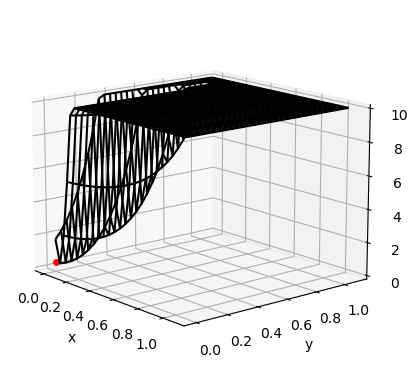

In [10]:
b_draw_u_loss = widgets.Button(description="Draw U")
def disable_us(value):
    b_draw_u_loss.disabled=value
    w_elevation_u.disabled=value
    w_azimuth_u.disabled=value
    w_max_clip_u.disabled=value
    w_eigen_1_u.disabled=value
    w_eigen_2_u.disabled=value

def draw_u():
    disable_us(True)
    fig_u = plt.figure()
    ax_u = plot_2D_surface(l_u, u_vec_ac, w_eigen_1_u.value, w_eigen_2_u.value,
                           u_eig_vects, max_clip=float(w_max_clip_u.value))
    globals()["ax_u"] = ax_u
    globals()["fig_u"] = fig_u     
    disable_us(False)
    
def click_b_draw_u_loss(change):    
    draw_u()
    
    
b_draw_u_loss.on_click(click_b_draw_u_loss)

w_elevation_u = widgets.IntSlider(
    value=240,
    min=0,
    max=360,
    step=1,
    description='Elevation:',
    disabled=False,
    continuous_update=False,    
)
w_azimuth_u = widgets.IntSlider(
    value=45,
    min=-179,
    max=180,
    step=1,
    description='Azimuth angle:',
    disabled=False,
    continuous_update=False,    
)

w_max_clip_u = widgets.Dropdown(
    options=['1','1e1', '1e2', '1e3', '1e4', '1e5', '1e6', '1e7', '1e8'],
    value='1e4',
    description='Clip:',
    disabled=False,
)

w_eigen_1_u = widgets.Dropdown(
    options=[0, 1, 2, 3],
    value=0,
    description='First eigenvalue:',
    disabled=False,
)

w_eigen_2_u = widgets.Dropdown(
    options=[0, 1, 2, 3],
    value=1,
    description='First eigenvalue:',
    disabled=False,
)

def plot_3D_u(elev, azimuth):    
    ax_u = globals()["ax_u"]
    fig_u = globals()["fig_u"]
    ax_u.view_init(elev, azimuth, 0)
    clear_output(wait=True)
    display(b_draw_u_loss, w_max_clip_u)
    display(w_eigen_1_u, w_eigen_2_u)
    display(w_elevation_u, w_azimuth_u)
    display(fig_u)   

def on_rotation_u_change(change):
    plot_3D_u(w_elevation_u.value, w_azimuth_u.value)
    
def on_redraw_u(change):
    draw_u()    
    plot_3D_u(w_elevation_u.value, w_azimuth_u.value)
    clear_output(wait=True)
    display(b_draw_u_loss, w_max_clip_u)
    display(w_eigen_1_u, w_eigen_2_u)
    display(w_elevation_u, w_azimuth_u)


w_elevation_u.observe(on_rotation_u_change, names='value')
w_azimuth_u.observe(on_rotation_u_change, names='value')
w_max_clip_u.observe(on_redraw_u, names='value')
w_eigen_1_u.observe(on_redraw_u, names='value')
w_eigen_2_u.observe(on_redraw_u, names='value')

display(b_draw_u_loss, w_max_clip_u)
display(w_eigen_1_u, w_eigen_2_u)
display(w_elevation_u, w_azimuth_u)


Button(description='Draw V', style=ButtonStyle())

Dropdown(description='Clip:', index=7, options=('1', '1e2', '1e3', '1e4', '1e5', '1e6', '1e7', '1e8'), value='…

Dropdown(description='First eigenvalue:', options=(0, 1, 2), value=0)

Dropdown(description='First eigenvalue:', index=2, options=(0, 1, 2), value=2)

IntSlider(value=29, continuous_update=False, description='Elevation:', max=360)

IntSlider(value=-68, continuous_update=False, description='Azimuth angle:', max=180, min=-179)

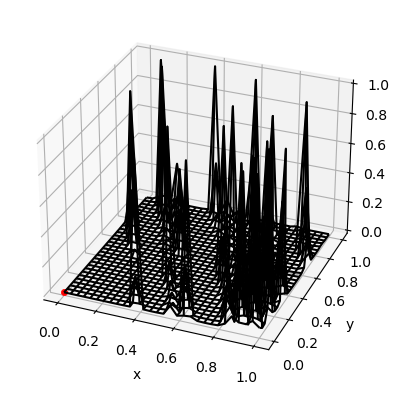

In [116]:
b_draw_v_loss = widgets.Button(description="Draw V")
def disable_vs(value):
    b_draw_v_loss.disabled=value
    w_elevation_v.disabled=value
    w_azimuth_v.disabled=value
    w_max_clip_v.disabled=value
    w_eigen_1_v.disabled=value
    w_eigen_2_v.disabled=value

def draw_v():
    disable_vs(True)
    fig_v = plt.figure()
    ax_v = plot_2D_surface(l_v, v_vec_ac, w_eigen_1_v.value, w_eigen_2_v.value,
                           v_eig_vects, max_clip=float(w_max_clip_v.value))
    globals()["ax_v"] = ax_v
    globals()["fig_v"] = fig_v     
    disable_vs(False)
    
def click_b_draw_v_loss(change):    
    draw_v()
    
    
b_draw_v_loss.on_click(click_b_draw_v_loss)

w_elevation_v = widgets.IntSlider(
    value=240,
    min=0,
    max=360,
    step=1,
    description='Elevation:',
    disabled=False,
    continuous_update=False,    
)
w_azimuth_v = widgets.IntSlider(
    value=45,
    min=-179,
    max=180,
    step=1,
    description='Azimuth angle:',
    disabled=False,
    continuous_update=False,    
)

w_max_clip_v = widgets.Dropdown(
    options=['1', '1e2', '1e3', '1e4', '1e5', '1e6', '1e7', '1e8'],
    value='1e4',
    description='Clip:',
    disabled=False,
)

w_eigen_1_v = widgets.Dropdown(
    options=[0, 1, 2],
    value=0,
    description='First eigenvalue:',
    disabled=False,
)

w_eigen_2_v = widgets.Dropdown(
    options=[0, 1, 2],
    value=1,
    description='First eigenvalue:',
    disabled=False,
)

def plot_3D_v(elev, azimuth):    
    ax_v = globals()["ax_v"]
    fig_v = globals()["fig_v"]
    ax_v.view_init(elev, azimuth, 0)
    clear_output(wait=True)
    display(b_draw_v_loss, w_max_clip_v)
    display(w_eigen_1_v, w_eigen_2_v)
    display(w_elevation_v, w_azimuth_v)
    display(fig_v)   

def on_rotation_v_change(change):
    plot_3D_v(w_elevation_v.value, w_azimuth_v.value)
    
def on_redraw_v(change):
    draw_v()    
    plot_3D_v(w_elevation_v.value, w_azimuth_v.value)
    clear_output(wait=True)
    display(b_draw_v_loss, w_max_clip_v)
    display(w_eigen_1_v, w_eigen_2_v)
    display(w_elevation_v, w_azimuth_v)


w_elevation_v.observe(on_rotation_v_change, names='value')
w_azimuth_v.observe(on_rotation_v_change, names='value')
w_max_clip_v.observe(on_redraw_v, names='value')
w_eigen_1_v.observe(on_redraw_v, names='value')
w_eigen_2_v.observe(on_redraw_v, names='value')

display(b_draw_v_loss, w_max_clip_v)
display(w_eigen_1_v, w_eigen_2_v)
display(w_elevation_v, w_azimuth_v)